# Import libraries.

In [1]:
# compare the data/mc veto efficiencies for jet veto and rechit vetos

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
import awkward as ak
from coffea.nanoevents.methods import vector, candidate
import math
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys
from numba import jit
import pandas as pd
import pdb
# if not sys.warnoptions:
import warnings

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys
import imageio.core.util

def silence_imageio_warning(*args, **kwargs):
    pass

imageio.core.util._precision_warns_ = silence_imageio_warning

warnings.simplefilter("ignore")

def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while np.count_nonzero(ak.flatten(dphi) > math.pi):
        dphi = dphi - (dphi > math.pi)*2*math.pi
    while np.count_nonzero(ak.flatten(dphi) <= -math.pi):
        dphi = dphi + (dphi <= -math.pi)*2*math.pi
    return dphi
lumi = 41600

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.24/06


/uscms_data/d3/ahayrape/mamba/envs/btollpk/lib/python3.9/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'awkward.numba' failed to load due to 'FileNotFoundError([Errno 2] No such file or directory: '/uscms_data/d3/ahayrape/mamba/envs/btollpk/lib/python3.9/site-packages/numpy-1.23.2.dist-info/METADATA')'.
  numba.core.entrypoints.init_all()


3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:45:29) 
[GCC 10.4.0]


# Load datasets.

In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
years = ['17']
category = 0
ver = 'V1p17'
sig_ver = 'v52'
singleMuon = True
bkg_path = '/eos/uscms/store/user/ahayrape/DY_BParking_v2/'

if sig_ver == 'v52':fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'
else:fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_137000pb_weighted.root'
for y in years:
    data_path = "/eos/uscms/store/user/ahayrape/DY_BParking_v2/"
    if y == '16':fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root"
    elif y == '17':fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"
    else:fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root"

signal_samples_dir = "/eos/uscms/store/user/ahayrape/Signal_datasets"
signal_samples = os.listdir(signal_samples_dir)
for i in signal_samples:
    fpath_bkg[i.split(".root")[0]] = f"{signal_samples_dir}/{i}"

for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']

lumi = 41600

dy_120_800 /eos/uscms/store/user/ahayrape/DY_BParking_v2/ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root
data17 /eos/uscms/store/user/ahayrape/DY_BParking_v2/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
PhiToPi0Pi0_mPhi0p3_ctau300 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPi0Pi0_mPhi0p3_ctau300.root
PhiToPi0Pi0_mPhi1p0_ctau1000 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPi0Pi0_mPhi1p0_ctau1000.root
PhiToPiPlusPiMinus_mPhi0p3_ctau300 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPiPlusPiMinus_mPhi0p3_ctau300.root
PhiToPiPlusPiMinus_mPhi1p0_ctau1000 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPiPlusPiMinus_mPhi1p0_ctau1000.root
PhiToPiPlusPiMinus_mPhi1p0_ctau300 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPiPlusPiMinus_mPhi1p0_ctau300.root


# Get variables and cutflow tables.

In [3]:
###########
# 0: jetveto; 1:muon veto; 2: me11 veto; 3: me12 veto; 4: re12 veto; 5 mb1 segment veto; 6: rb1 veto; 7: mb1 rechit veto; 8: all rechit/segment vetos
###########

veto = 0
veto_names = ['me1112_veto', 're12',  'mb1_seg', 'rb1_veto', 'muon_veto', 'jet_veto', "rec_seg_veto", "probe_muon_cluster"] # For CSC
veto_yaxis = ['ME1112 Veto Efficiency', 'RE12 Veto efficiency', 'MB1 Veto Efficiency', 'RB1 Veto Efficiency', 'Muon Veto', 'Jet Veto', 'Rechit/Segment Veto', 'Probe Muon cluster']

jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
ZPt = {}
ZMass = {}
nJets = {}
sel_lep = {}
sel_ev = {}
mc_corr_weight = {}
lepOverallSF = {}
nJets2 = {}
jetPt = {}
jetPhi = {}
jetEta = {}
muonPt = {}
muonPhi = {}
muonEta = {}
clusterSize = {}
probe_muonPhi = {}
probe_muonEta = {}
npu = {}
npv = {}

cscRechitClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitCluster_match_gLLP_other_decay_r = {}
cscRechitCluster_match_gLLP_other_decay_z = {}
cscRechitClusterRE12 = {}
cscRechitClusterRB1 = {}
cscRechitClusterMB1 = {}
cscRechitClusterME11 = {}
cscRechitClusterMB1Rechit = {}
cscRechitClusterME12 = {}
cscRechitClusterSize = {}

dtRechitClusterJetVetoPt = {}
dtRechitClusterEta = {}
dtRechitClusterPhi = {}

re12_eta = {}
re12_phi = {}
re12_X = {}
re12_Y = {}
re12_Z = {}
rb1_eta = {}
rb1_phi = {}
rb1_X = {}
rb1_Y = {}
rb1_Z = {}

mb1_phi = {}
mb1_eta = {}
mb1_rechit_eta = {}
mb1_rechit_phi = {}
me11_eta = {}
me11_phi = {}
me12_eta = {}
me12_phi = {}
all_eta = {}
all_phi = {}

rpc_eta = {}
rpc_phi = {}
rpcX = {}
rpcY = {}
rpcZ = {}

me1112_veto_eta = {}
me1112_veto_phi = {}
re12_seg_eta = {}
re12_seg_phi = {}
mb1_seg_eta = {}
mb1_seg_phi = {}
rb1_eta = {}
rb1_phi = {}
cut_based_ID_eta = {}
cut_based_ID_phi = {}
eta_cut_eta = {}
eta_cut_phi = {}

RPC_Bx_eta = {}
RPC_Bx_phi = {}
RPC_Hits_eta = {}
RPC_Hits_phi = {}
RPC_Hits_phi = {}
RPC_Hits_eta = {}
mb1_phi = {}
mb1_eta = {}
mb1_rechit_phi = {}
mb1_rechit_eta = {}
probe_sel = {}

muonPt = 50
norm = 50
tag_probe = True
masses = [('120','800')]
cluster_index = ''

for k, T in tree_bkg.items():
########## select cluster ########
    arrays = T.arrays()
    sel_rechitcluster = np.ones(len(arrays['cscRechitCluster' + cluster_index + 'Eta']), dtype = bool)

# ########### BRANCHES ############
    if "PhiTo" in k:

        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # /////////////////////////////////////////////////// CHANGE SECTION /////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

        cut_based_id_0 = np.logical_and(arrays['cscRechitCluster' + cluster_index + 'NStation10'] >  1, arrays['cscRechitCluster' + cluster_index + 'Eta'] < 1.8)
        cut_based_id_4 = np.logical_and(np.logical_and(arrays['cscRechitCluster' + cluster_index + 'NStation10'] == 1, arrays['cscRechitCluster' + cluster_index + 'AvgStation10'] == 4), arrays['cscRechitCluster' + cluster_index + 'Eta'] < 1.8)
        cut_based_id_3 = np.logical_and(np.logical_and(arrays['cscRechitCluster' + cluster_index + 'NStation10'] == 1, arrays['cscRechitCluster' + cluster_index + 'AvgStation10'] == 3), arrays['cscRechitCluster' + cluster_index + 'Eta'] < 1.6)
        cut_based_id_2 = np.logical_and(np.logical_and(arrays['cscRechitCluster' + cluster_index + 'NStation10'] == 1, arrays['cscRechitCluster' + cluster_index + 'AvgStation10'] == 2), arrays['cscRechitCluster' + cluster_index + 'Eta'] < 1.7)
        cut_based_id_1 = np.logical_and(np.logical_and(arrays['cscRechitCluster' + cluster_index + 'NStation10'] == 1, arrays['cscRechitCluster' + cluster_index + 'AvgStation10'] == 1), arrays['cscRechitCluster' + cluster_index + 'Eta'] < 1.1)
        cut_based_id = np.logical_or(np.logical_or(np.logical_or(cut_based_id_0, cut_based_id_1), np.logical_or(cut_based_id_2, cut_based_id_3)), cut_based_id_4)

        muon = (np.abs(arrays["lepPdgId"]) == 13)
        m_eta = arrays["lepEta"][muon]
        m_phi = arrays["lepPhi"][muon]
        m_pt  = arrays["lepPt" ][muon]
        m_DZ  = arrays["lepDZ" ][muon]
        m_HLT = arrays["lepMuon_passHLTFilter"][muon]
        m_LooseId = arrays["lepLooseId"][muon]
        m_TightId = arrays["lepTightId"][muon]
        m_Type = arrays["lepMuonType"][muon]
        m_Quality = arrays["lepMuonQuality"][muon]
        m_passHLTFilter = arrays["lepMuon_passHLTFilter"][muon]

        selections = (m_eta < 1.5) & (m_pt > 7) & (ak.any(m_HLT[:,:,range(60,68)], axis=2)) & (m_Quality >= 2**25)# 
        m_eta = m_eta[selections]
        m_phi = m_phi[selections]
        m_pt  = m_pt [selections]

        leadcut = (ak.max(m_pt, axis=1, mask_identity=True) == m_pt) ## 
        m_eta = m_eta[leadcut]
        m_phi = m_phi[leadcut]
        m_pt  = m_pt [leadcut]

        # check the number muons for data and dy
        # check with AN for RPC matching

        # For CSC
        pairs = ak.cartesian({
            "RechitClusters":  ak.zip({"eta": arrays['cscRechitClusterEta'], \
                                       "phi": arrays['cscRechitClusterPhi']}, with_name = 'PtEtaPhiMLorentzVector', behavior = vector.behavior),
            "muons"         :  ak.zip({"eta": m_eta                        , \
                                       "phi": m_phi                       }, with_name = 'PtEtaPhiMLorentzVector', behavior = vector.behavior)
        }, nested = True)

        dr   = (pairs.muons).delta_r  (pairs.RechitClusters)
        dphi = (pairs.muons).delta_phi(pairs.RechitClusters)
        DR_cls_muons    = ak.any(dr   > 0.8, axis = 2)
        SignalRegionCut = ak.any(dphi > 1.9, axis = 2)
        del pairs
        del dphi
        del dr

        pairs = ak.cartesian({
            "RechitClusters":  ak.zip({"eta": arrays['cscRechitClusterEta'], \
                                       "phi": arrays['cscRechitClusterPhi']}, with_name = 'PtEtaPhiMLorentzVector', behavior = vector.behavior),
            "llps"          :  ak.zip({"eta": arrays['gLLP_eta']          , \
                                       "phi": arrays['gLLP_phi']          }, with_name = 'PtEtaPhiMLorentzVector', behavior = vector.behavior)
        }, nested = True)
        dr = (pairs.llps).delta_r(pairs.RechitClusters)
        DR_cls_llp = ak.any(dr < 0.4, axis = 2)
        del pairs
        del dr

        names = [
            # 'cluster_size',
            'ME1112',
            'LLP_matching',
            'Muon_cluster rejection',
            'RE12',
            'MB1_Seg',
            'RB1',
            'Muon Veto',
            'Time cut',
            'Time spread cut',
            'Cluster Eta cut',
            'Cut-Based ID',
            # 'Cluster size'
         ]

        veto_sel = [
            # arrays['cscRechitClusterSize']>=50,
            DR_cls_llp,
            DR_cls_muons,
            # np.logical_and(np.logical_and(np.logical_and(arrays['cscRechitCluster' + cluster_index + 'NRechitChamberPlus11'] == 0, arrays['cscRechitCluster' + cluster_index + 'NRechitChamberMinus11'] == 0), arrays['cscRechitCluster' + cluster_index + 'NRechitChamberPlus12'] == 0), arrays['cscRechitCluster' + cluster_index + 'NRechitChamberMinus12'] == 0),
            arrays['cscRechitCluster' + cluster_index + '_match_RE12_0p4'] == 0,
            arrays['cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4'] == 0,
            arrays['cscRechitCluster' + cluster_index + '_match_RB1_0p4'] == 0,
            arrays['cscRechitClusterMuonVetoPt'] < 20,
            np.logical_and(arrays['cscRechitCluster' + cluster_index + 'TimeWeighted'] <= 12.5, arrays['cscRechitCluster' + cluster_index + 'TimeWeighted'] >= -5),
            arrays["cscRechitClusterTimeSpreadWeightedAll"] <= 20,
            np.abs(arrays['cscRechitCluster' + cluster_index + 'Eta']) < 1.9,
            cut_based_id,
            # arrays['cscRechitClusterSize']>=390,
        ]

        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # /////////////////////////////////////////////////// CHANGE SECTION /////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

        for v in veto_sel:
            sel_rechitcluster = np.logical_and(sel_rechitcluster, v)

        HLT_MU_IP_sel = range(1157, 1197)
        sel_ev[k] = ak.any(arrays['HLTDecision'][:,HLT_MU_IP_sel], axis = 1)
        sel_ev[k] = np.logical_and(sel_ev[k], (arrays['nCscRechitClusters'] > 0))
        sel_ev[k] = np.logical_and(sel_ev[k], (arrays['gLLP_csc'] > 0))

        print(f'\n{k}')
        prev_number = 1.0
        cutflow_table = veto_sel[0]
        print(f'0) - ({names[0]}) - {100.0 * np.sum(np.any(cutflow_table, axis = 1))/prev_number}')
        for s in range(len(veto_sel)):
            if s == 0: continue
            prev_number = np.sum(ak.any(cutflow_table, axis=1))
            cutflow_table = np.logical_and(cutflow_table, veto_sel[s])
            print(f'{s}) - ({names[s]}) - {100.0 * np.sum(np.any(cutflow_table, axis = 1))/prev_number}')
        
        # Signal region.
        signal_region = np.logical_and(SignalRegionCut, arrays['cscRechitClusterSize'] > 130)
        fail_region_1 = np.logical_and(SignalRegionCut, np.logical_not(arrays['cscRechitClusterSize'] > 130))
        fail_region_2 = np.logical_and(np.logical_not(SignalRegionCut), arrays['cscRechitClusterSize'] > 130)
        fail_region_3 = np.logical_and(np.logical_not(SignalRegionCut), np.logical_not(arrays['cscRechitClusterSize'] > 130))
        
        print("SIGNAL region: ", 100 * np.sum(np.any(np.logical_and(cutflow_table, signal_region), axis = 1)) / np.sum(np.any(cutflow_table, axis=1)))
        print("Fail region 1: ", 100 * np.sum(np.any(np.logical_and(cutflow_table, fail_region_1), axis = 1)) / np.sum(np.any(cutflow_table, axis=1)))
        print("Fail region 2: ", 100 * np.sum(np.any(np.logical_and(cutflow_table, fail_region_2), axis = 1)) / np.sum(np.any(cutflow_table, axis=1)))
        print("Fail region 3: ", 100 * np.sum(np.any(np.logical_and(cutflow_table, fail_region_3), axis = 1)) / np.sum(np.any(cutflow_table, axis=1)))
        
        no_clusters = (ak.count( arrays['cscRechitCluster' + cluster_index + 'Eta'][sel_rechitcluster][sel_ev[k]], axis = 1) > 0)
        cscRechitClusterEta[k] = arrays['cscRechitCluster' + cluster_index + 'Eta'][sel_rechitcluster][sel_ev[k]][no_clusters][:,0]
        cscRechitClusterPhi[k] = arrays['cscRechitCluster' + cluster_index + 'Phi'][sel_rechitcluster][sel_ev[k]][no_clusters][:,0]
        cscRechitClusterSize[k] = arrays['cscRechitCluster' + cluster_index + 'Size'][sel_rechitcluster][sel_ev[k]][no_clusters][:,0]
        weight[k] = (arrays['weight'])[sel_ev[k]][no_clusters]
    else:
        sel_lep[k] = np.logical_and(arrays['lepTightId']==1, arrays["lepPassTightIso"]==1) # tight iso+id lepton
        sel_lep[k] = np.logical_and(sel_lep[k], np.abs(arrays["lepPdgId"])==13)            # tight iso+id lepton
        sel_ev[k] = np.sum(sel_lep[k], axis = 1)>=1
        sel_ev[k] = np.logical_and(sel_ev[k], np.sum(arrays['lepPt']>= muonPt, axis = 1)==2)
        if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], np.sum(arrays['lepFromZ'], axis = 1)==2)
        sel_ev[k] = np.logical_and(sel_ev[k], arrays["Flag2_all"])
        sel_ev[k] = np.logical_and(sel_ev[k], arrays['category']==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
        sel_ev[k] = np.logical_and(sel_ev[k], arrays['ZMass']>=120)
        sel_ev[k] = np.logical_and(sel_ev[k], arrays['ZMass']<800)
        weight[k] = arrays['weight'][sel_ev[k]]*lumi
        pileupWeight[k] = arrays['pileupWeight'][sel_ev[k]]
        if k[:2] == 'dy': lepOverallSF[k] = arrays['lepOverallSF'][sel_ev[k]]
        ZMass[k]= arrays['ZMass'][sel_ev[k]]
        ZPt[k] = arrays['ZPt'][sel_ev[k]]
        nJets[k] = arrays['nJets'][sel_ev[k]]
        clusterSize[k] = arrays['cscRechitClusterSize'][sel_ev[k]]

        sel_jet = np.logical_and(np.abs(arrays['jetEta']) <=2.0, np.abs(arrays['jetEta']) >0.8)
        nJets2[k] = (np.sum(sel_jet, axis = 1))[sel_ev[k]]
        jetPt[k] = arrays['jetPt'][sel_jet][sel_ev[k]]
        jetEta[k] = arrays['jetEta'][sel_jet][sel_ev[k]]
        jetPhi[k] = arrays['jetPhi'][sel_jet][sel_ev[k]]
        muonEta[k] = arrays['lepEta'][np.abs(arrays["lepPdgId"]) == 13]
        muonPhi[k] = arrays['lepPhi'][np.abs(arrays["lepPdgId"]) == 13]
        sel_muon = np.logical_and(np.abs(muonEta[k]) <= 2.0, np.abs(muonEta[k]) > 0.8)
        muonEta[k] = muonEta[k][sel_muon][sel_ev[k]]
        muonPhi[k] = muonPhi[k][sel_muon][sel_ev[k]]
        # tag_muonEta[k] = muonEta[k][sel_muon][sel_ev[k]]
        # tag_muonPhi[k] = muonPhi[k][sel_muon][sel_ev[k]]
        # probe_sel[k] = np.logical_and(arrays['lepLooseId']==1, arrays["lepPassLooseIso"]==1)
        # probe_sel[k] = np.logical_and(probe_sel[k], np.abs(arrays['lepPdgId'])==13)
        
        probe_sel[k] = np.logical_and(arrays['lepTightId']==1, arrays["lepPassTightIso"]==1)
        probe_sel[k] = np.logical_and(probe_sel[k], np.abs(arrays['lepPdgId'])==13)
        
        probe_muonEta[k] = arrays['lepEta'][probe_sel[k]]
        probe_muonPhi[k] = arrays['lepPhi'][probe_sel[k]]
        sel_muon = np.logical_and(np.abs(probe_muonEta[k]) <= 2.0, np.abs(probe_muonEta[k]) > 0.8)
        probe_muonEta[k] = probe_muonEta[k][sel_muon][sel_ev[k]]
        probe_muonPhi[k] = probe_muonPhi[k][sel_muon][sel_ev[k]]
        re12_eta[k] = arrays['rpcEta'][arrays['rpc_RE12']][sel_ev[k]]
        re12_phi[k] = arrays['rpcPhi'][arrays['rpc_RE12']][sel_ev[k]]
        re12_X[k]   = arrays['rpcX'][arrays['rpc_RE12']][sel_ev[k]]
        re12_Y[k]   = arrays['rpcY'][arrays['rpc_RE12']][sel_ev[k]]
        re12_Z[k]   = arrays['rpcZ'][arrays['rpc_RE12']][sel_ev[k]]
        rb1_eta[k]  = arrays['rpcEta'][arrays['rpc_RB1']][sel_ev[k]]
        rb1_phi[k]  = arrays['rpcPhi'][arrays['rpc_RB1']][sel_ev[k]]
        rb1_X[k]    = arrays['rpcX'][arrays['rpc_RB1']][sel_ev[k]]
        rb1_Y[k]    = arrays['rpcY'][arrays['rpc_RB1']][sel_ev[k]]
        rb1_Z[k]    = arrays['rpcZ'][arrays['rpc_RB1']][sel_ev[k]]

        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # /////////////////////////////////////////////////// CHANGE SECTION /////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

        me11_eta[k] = arrays['cscRechitsEta'][np.abs(arrays['cscRechitsChamber']) == 11][sel_ev[k]]
        me11_phi[k] = arrays['cscRechitsPhi'][np.abs(arrays['cscRechitsChamber']) == 11][sel_ev[k]]
        me12_eta[k] = arrays['cscRechitsEta'][np.abs(arrays['cscRechitsChamber']) == 12][sel_ev[k]]
        me12_phi[k] = arrays['cscRechitsPhi'][np.abs(arrays['cscRechitsChamber']) == 12][sel_ev[k]]
        mb1_seg_eta[k] = arrays['dtSegEta'][(arrays['dtSegStation'] == 1)][sel_ev[k]]
        mb1_seg_phi[k] = arrays['dtSegPhi'][(arrays['dtSegStation'] == 1)][sel_ev[k]]
        me1112 = (np.logical_or(np.abs(arrays['cscRechitsChamber']) == 11, np.abs(arrays['cscRechitsChamber']) == 12))
        me1112_veto_eta[k] = arrays['cscRechitsEta'][me1112][sel_ev[k]]
        me1112_veto_phi[k] = arrays['cscRechitsPhi'][me1112][sel_ev[k]]
        
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # /////////////////////////////////////////////////// CHANGE SECTION /////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        
        no_clusters = (ak.count( arrays['cscRechitCluster' + cluster_index + 'Eta'][sel_ev[k]], axis = 1) > 0)
        cscRechitClusterSize[k] = arrays['cscRechitCluster' + cluster_index + 'Size'][sel_ev[k]][no_clusters][:,0]

        mc_corr_weight[k] = np.array(arrays['ZMass'][sel_ev[k]])
        print(mc_corr_weight[k])
        if norm == 50:
            mc_corr_weight[k][np.logical_and(ZMass[k]>=50 ,ZMass[k]<120)] = 1.0734578
            mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
            mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
            mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247

        if 'dy' in k:  weight[k] = (arrays['weight'] * arrays['pileupWeight'])[sel_ev[k]] * mc_corr_weight[k] * lumi
        else: weight[k] = np.ones(len(ZMass[k]))

    npu[k] = arrays['npu'][sel_ev[k]]
    npv[k] = arrays['npv'][sel_ev[k]]

CLUSTER_PER_EVT = 5

[136.32512 135.61577 137.63548 ... 458.05554 439.31284 435.80206]
[139.35695  122.094505 203.48758  ... 151.32489  221.36615  129.94862 ]

PhiToPi0Pi0_mPhi0p3_ctau300
0) - (ME1112) - 1107700.0
1) - (LLP_matching) - 13.333935181005687
2) - (Muon_cluster rejection) - 75.76167907921463
3) - (RE12) - 99.19571045576407
4) - (MB1_Seg) - 98.91891891891892
5) - (RB1) - 99.18032786885246
6) - (Muon Veto) - 98.71441689623508
7) - (Time cut) - 94.88372093023256
8) - (Time spread cut) - 54.31372549019608
9) - (Cluster Eta cut) - 36.28158844765343
SIGNAL region:  9.950248756218905
Fail region 1:  23.880597014925375
Fail region 2:  15.92039800995025
Fail region 3:  50.24875621890547

PhiToPi0Pi0_mPhi1p0_ctau1000
0) - (ME1112) - 1223100.0
1) - (LLP_matching) - 12.877115526122148
2) - (Muon_cluster rejection) - 76.44444444444444
3) - (RE12) - 98.421926910299
4) - (MB1_Seg) - 98.90295358649789
5) - (RB1) - 99.40273037542661
6) - (Muon Veto) - 98.71244635193133
7) - (Time cut) - 94.08695652173913
8) - (

# Make the efficiency plots and get the inclusive efficiencies with errors.

In [4]:
keys = list(cscRechitClusterSize.keys())
keys

['dy_120_800',
 'data17',
 'PhiToPi0Pi0_mPhi0p3_ctau300',
 'PhiToPi0Pi0_mPhi1p0_ctau1000',
 'PhiToPiPlusPiMinus_mPhi0p3_ctau300',
 'PhiToPiPlusPiMinus_mPhi1p0_ctau1000',
 'PhiToPiPlusPiMinus_mPhi1p0_ctau300']

In [7]:
len(signal_yield)

7

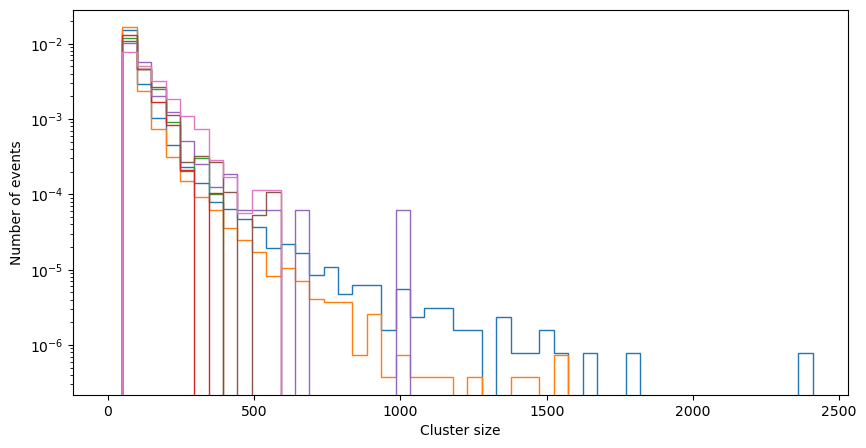

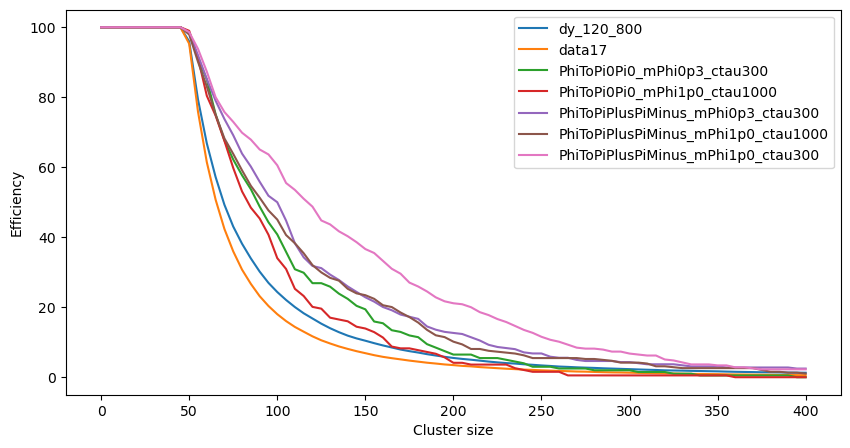

    Cut values  dy_120_800  data17  PhiToPi0Pi0_mPhi0p3_ctau300  PhiToPi0Pi0_mPhi1p0_ctau1000  PhiToPiPlusPiMinus_mPhi0p3_ctau300  PhiToPiPlusPiMinus_mPhi1p0_ctau1000  PhiToPiPlusPiMinus_mPhi1p0_ctau300
0          0.0      100.00  100.00                       100.00                        100.00                              100.00                               100.00                              100.00
1          5.0      100.00  100.00                       100.00                        100.00                              100.00                               100.00                              100.00
2         10.0      100.00  100.00                       100.00                        100.00                              100.00                               100.00                              100.00
3         15.0      100.00  100.00                       100.00                        100.00                              100.00                               100.00                      

In [9]:
keys = list(cscRechitClusterSize.keys())
max_values = [max(i) for i in list(cscRechitClusterSize.values())]
a = 5
fig, ax = plt.subplots(1, figsize = (a*2, a*1))
fig_eff, ax_eff = plt.subplots(1, figsize = (a*2, a*1))
cut_values = np.linspace(0, 40, 81) * 10
columns = ["Cut values"]
data_matrix = []
signal_yield = []
data_matrix.append(cut_values)
signal_yield.append(cut_values)
# print(cut_values)
for i in range(len(keys)):
    key = keys[i]
    # if "Phi" in keys[i]: continue
    eff = []
    signal_y = []
    variable = np.array(cscRechitClusterSize[key])
    for j in cut_values:
        eff.append(np.around(np.sum(variable > j)*100/len(variable), 2))
        signal_y.append(len(variable[variable > j]))
    # print(50, key, np.round(np.sum(variable > 50)*100/len(variable), 2))
    # print(390, key, np.round(np.sum(variable > 390)*100/len(variable), 2))
    # print()
    columns.append(key)
    data_matrix.append(eff)
    signal_yield.append(signal_y)
    bins = np.linspace(0, max(max_values), 50)
    ax.hist(variable, bins = bins, histtype = "step", label = keys[i], density = True)
    # print(eff)
    ax_eff.plot(cut_values, eff, label = keys[i])
ax.set_yscale("log")
ax.set_xlabel("Cluster size")
ax.set_ylabel("Number of events")

ax_eff.set_xlabel("Cluster size")
ax_eff.set_ylabel("Efficiency")

plt.legend()
plt.show()

data_frame = pd.DataFrame(data = np.array(data_matrix).T, columns = columns)
print(data_frame.to_string())

data_frame_1 = pd.DataFrame(data = np.array(signal_yield).T, columns = columns)
print(data_frame_1.to_string())

# print("Data, MC, WP, signal yield, ")

Veto:  7
eta phi to calculate simple DeltaR
data17 0.9706589386943734
eta phi to calculate simple DeltaR
dy_120_800 0.971006510898021
0.9976099326724831 0.0015620486204824316 1.000201509663056 0.002219739767240148
0.9989525358364799 0.0012394784117342706 0.9971633737192652 0.0019214769693479457
1.004191774571946 0.0035895805826433227 0.999176498189432 0.001966149990842036
1.0008413058199592 0.0022376822779591513 0.9987330378930496 0.0017338990420904018
0.9997055764808361 0.01759166169581201 1.0050828586355074 0.0034829518009584846
Veto:  7
eta phi to calculate simple DeltaR
data17 0.9704335716060584
eta phi to calculate simple DeltaR
dy_120_800 0.9707273646329226
0.9996962579958453 0.0016283501792977997 1.0005023333944678 0.0022520141102722394
0.9994261450395607 0.001260760364218752 0.9979524071865642 0.0019407321108752026
0.9948148381578859 0.003184895062739398 1.0007103148307563 0.0019505444999611094
0.9975229248228966 0.0020330538324152413 1.002545376180271 0.0018813514424045703
1.0

Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorUp>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorUp>: setting statistic option to kFNormal
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWei

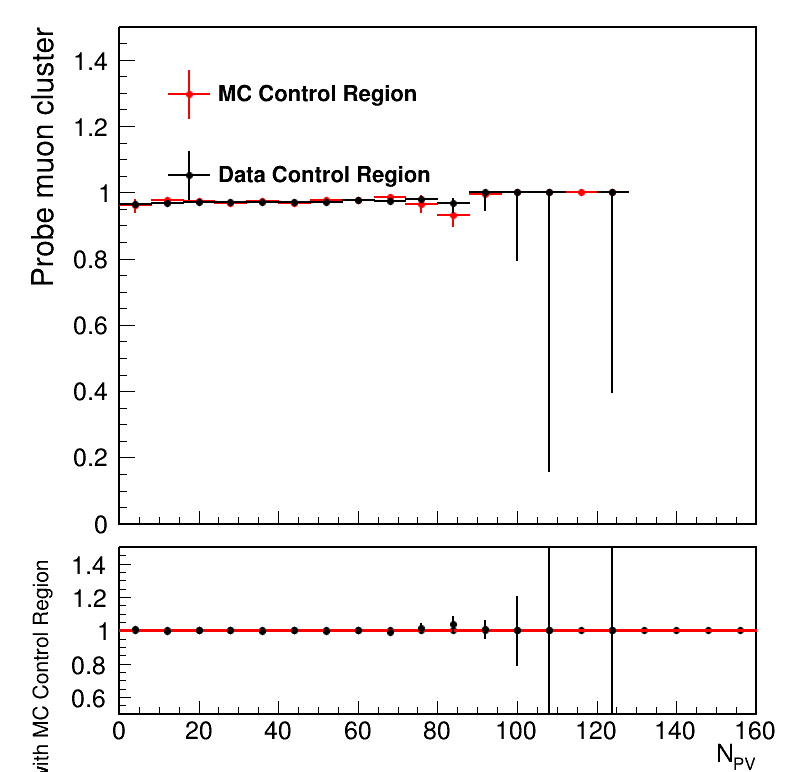

In [9]:
########### CSC
# 0: me1112 veto; 1:re12 veto; 2: mb1 seg veto; 3: rb1 veto; 4: muon veto; 5 jet veto; 6 rec_seg veto
###########
veto_names = ['me1112_veto', 're12',  'mb1_seg', 'rb1_veto', 'muon_veto', 'jet_veto', "rec_seg_veto", "probe_muon_cluster"] # For CSC
veto_yaxis = ['ME1112 Veto Efficiency', 'RE12 Veto efficiency', 'MB1 Veto Efficiency', 'RB1 Veto Efficiency', 'Muon Veto', 'Jet Veto', 'Rechit/Segment Veto', 'Probe muon cluster']

var_eta = [me1112_veto_eta, re12_eta, mb1_seg_eta, rb1_eta, muonEta, jetEta, rb1_eta, probe_muonEta] # For CSC
var_phi = [me1112_veto_phi, re12_phi, mb1_seg_phi, rb1_phi, muonPhi, jetPhi, rb1_phi, probe_muonPhi]

veto = 7
CLUSTER_PER_EVT = 1
integral = {}
for signal in signal_samples:
    signal = signal.split(".root")[0]
    matched = {}
    print("Veto: ", veto)
    for k in ['data17', 'dy_120_800']:
        hist, bins = np.histogram(np.abs(list(cscRechitClusterEta[signal])),bins = 48,range=[0.8,2.0],weights = list(weight[signal]))
        bin_width = bins[1]-bins[0]
        bin_midpoints = bins[:-1] + np.diff(bins)/2
        cdf = np.cumsum(hist)
        cdf = cdf / cdf[-1]
        values = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
        pos_in_bin = (np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))-0.5)*bin_width
        signs = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
        signs[signs < 0.5] = -1
        signs[signs >= 0.5] = 1
        #         if veto_names[veto] == "rec_seg_veto":
        #             index = 3
        #             values = np.random.rand(CLUSTER_PER_EVT*len(var_eta[index][k]))
        #             pos_in_bin = (np.random.rand(CLUSTER_PER_EVT*len(var_eta[index][k]))-0.5)*bin_width
        #             signs = np.random.rand(CLUSTER_PER_EVT*len(var_eta[index][k]))
        #             signs[signs < 0.5] = -1
        #             signs[signs >= 0.5] = 1
        #             value_bins = np.searchsorted(cdf, values)
        #             eta = bin_midpoints[value_bins]*signs+pos_in_bin
        #             # for phi, randomly pick a point between 0,360
        #             phi = np.random.randint(0,360,CLUSTER_PER_EVT*len(var_eta[index][k]))/180.0*math.pi
        #         else:
        value_bins = np.searchsorted(cdf, values)

        eta = bin_midpoints[value_bins]*signs+pos_in_bin
        # for phi, randomly pick a point between 0,360
        phi = np.random.randint(0,360,CLUSTER_PER_EVT*len(var_eta[veto][k]))/180.0*math.pi
            
        if veto_names[veto] == "rb1_veto":
            print("calculate deltaR between cluster the the jet/hits")
            deltaR = (        (eta-var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2+ \
                      deltaPhi(phi,var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2)**0.5
            rpcR   = np.sqrt(rb1_X[k]*rb1_X[k] + rb1_Y[k]*rb1_Y[k])
            req    = ((rpcR < 461.0) & (rpcR > 275) & (abs(rb1_Z[k]) > 663) & (abs(rb1_Z[k]) < 730))
            selecting = (ak.any(deltaR < 0.4, axis = 1)) & (req)
            print(len(eta), len(rb1_eta[k]), len(rpcR), len(req))
            matched[k] = ak.any(selecting, axis = 1)

        elif veto_names[veto] == "re12_veto":
            print("calculate deltaR between cluster the the jet/hits")
            deltaR = (        (eta-var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2+ \
                      deltaPhi(phi,var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2)**0.5
            rpcR   = np.sqrt(re12_X[k]*re12_X[k] + re12_Y[k]*re12_Y[k])
            req    = ((rpcR < 470) & (rpcR > 380) & (abs(re12_Z[k]) < 661))
            selecting = (ak.any(deltaR < 0.4, axis = 1)) & (req)
            matched[k] = ak.any(selecting, axis = 1)
        
        elif veto_names[veto] == "rec_seg_veto":
            print("calculate deltaR between cluster and the RPC")
            deltaR = (        (eta-rb1_eta[k][np.repeat(np.arange(len(rb1_eta[k])), CLUSTER_PER_EVT)])**2+ \
                      deltaPhi(phi,rb1_phi[k][np.repeat(np.arange(len(rb1_eta[k])), CLUSTER_PER_EVT)])**2)**0.5
            rpcR   = np.sqrt(rb1_X[k]*rb1_X[k] + rb1_Y[k]*rb1_Y[k])
            req    = ((rpcR < 461.0) & (rpcR > 275.0) & (abs(rb1_Z[k]) > 663.0) & (abs(rb1_Z[k]) < 730.0))
            print(len(eta), len(rb1_eta[k]), len(rpcR), len(req))
            selecting_rb1 = ak.any((ak.any(deltaR < 0.4, axis = 1)) & (req), axis = 1)
            
            print("calculate deltaR between cluster and the re12")
            deltaR = (        (eta-re12_eta[k][np.repeat(np.arange(len(re12_eta[k])), CLUSTER_PER_EVT)])**2 + \
                      deltaPhi(phi,re12_phi[k][np.repeat(np.arange(len(re12_eta[k])), CLUSTER_PER_EVT)])**2)**0.5
            rpcR   = np.sqrt(re12_X[k]*re12_X[k] + re12_Y[k]*re12_Y[k])
            req    = ((rpcR < 470.0) & (rpcR > 380.0) & (abs(re12_Z[k]) < 661.0))
            selecting_re12 = ak.any((ak.any(deltaR < 0.4, axis = 1)) & (req), axis = 1)
            
            print("calculate deltaR between cluster and the ME1112")
            deltaR = (        (eta-me1112_veto_eta[k][np.repeat(np.arange(len(me1112_veto_eta[k])), CLUSTER_PER_EVT)])**2+ \
                      deltaPhi(phi,me1112_veto_phi[k][np.repeat(np.arange(len(me1112_veto_eta[k])), CLUSTER_PER_EVT)])**2)**0.5
            selecting_me1112 = (ak.any(deltaR < 0.4, axis = 1))
            
            print("calculate deltaR between cluster and the MB1 seg")
            deltaR = (        (eta-mb1_seg_eta[k][np.repeat(np.arange(len(mb1_seg_eta[k])), CLUSTER_PER_EVT)])**2+ \
                      deltaPhi(phi,mb1_seg_phi[k][np.repeat(np.arange(len(mb1_seg_eta[k])), CLUSTER_PER_EVT)])**2)**0.5
            selecting_mb1_seg = (ak.any(deltaR < 0.4, axis = 1))
            
            print("Merging")
            all_vetoes = (selecting_rb1) & (selecting_re12) & (selecting_me1112) & (selecting_mb1_seg)
            
            print("Matched")
            matched[k] = all_vetoes
        else:
            print("eta phi to calculate simple DeltaR")
            deltaR = (        (eta-var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2+ \
                      deltaPhi(phi,var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2)**0.5
            matched[k] = ak.any(deltaR < 0.4, axis = 1)

        print(k, 1-np.count_nonzero(matched[k])/ len(deltaR))

    diff = {}
    diff_err = {}
    eff_data_err = {}
    eff_dy_err = {}
    eff_data = {}
    eff_dy = {} 
    for veto in range(len(veto_names)):
        if veto != 7: continue # SELECTIONS OF THE VETO
        c = rt.TCanvas('c','c', 800, 600)
        leg = rt.TLegend(0.2,0.80,0.4,0.90)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        hm = {}
        hb = {}
        pEff = {}
        var = [ZMass, ZPt, nJets, nJets2, npv]
        title = ['Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'Number of Jets', 'Number of Jets', 'N_{PV}']
        bins = [ [25,120,800], [0,20,40,60,80,100,200,300,400,500,600,1200], [10,0,20], [15,0,15],  [20,0,160]]
        names = ['ZMass', 'ZPt', 'nJets', 'nJets_eta2', 'npv']
        ratio = [[0.5,1.5], [0.5,1.5], [0.5,1.5],[0.5,1.5],[0.5,1.5]]
        assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )
        dir_name = f"./Veto_efficiency_{signal}_CSC/"
        os.system(f"mkdir -p {dir_name}")
        reweight = 0
        reweight_index = 1
        for j in range(len(bins)):
            inc_int = {}
            inc_int_err = {}
            for i, k in enumerate(['data17', 'dy_120_800', signal]):
                if k == signal and j != 4:continue
                total_weight = weight[k]
                if k == 'data': total_weight = total_weight * 0.0 + 1
                ###########
                # reweight
                ##########
                if k == 'dy_120_800' and reweight:
                    h_reweight = {}
                    h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = total_weight)
                    h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index])
                    for key, v in h_reweight.items():v.Scale(1./v.Integral())
                    h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
                    reweight = []
                    for m in range(len(var[j][k])):
                        reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
                    total_weight = total_weight * np.array(reweight)

                if k == signal:
                    outside = np.ones(len(cscRechitClusterEta[signal]), dtype = bool)
                    nominator = np.ones(len(cscRechitClusterEta[signal]), dtype = bool)
                    hm[k] = create_TH1D(np.abs(var[j][k][nominator]), 'hm1', axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[nominator]) 
                    hb[k] = create_TH1D(np.abs(var[j][k][outside]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[outside])
                    m = create_TH1D(np.abs(var[j][k][nominator]), 'hm1', axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[nominator]) 
                    b = create_TH1D(np.abs(var[j][k][outside]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[outside])
                    pEff_inclusive = rt.TEfficiency(m,b)

                else:
                    hm[k] = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]), 'hm1',\
                                        axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]) 
                    hb[k] = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], \
                                        binning=bins[j], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)])
                    m = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]), 'hm1',\
                                        axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]) 
                    b = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], \
                                            binning=[1,0,1000], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)])
                    pEff_inclusive = rt.TEfficiency(m,b)
                    inc_int[k] = pEff_inclusive.GetEfficiency(1)
                    inc_int_err[k] = pEff_inclusive.GetEfficiencyErrorUp(1)

                pEff[k] = rt.TEfficiency(hm[k],hb[k])
                pEff[k].SetLineColor(std_color_list[i])
                pEff[k].SetMarkerColor(std_color_list[i])
                pEff[k].SetLineWidth(2)

            diff        [veto_names[veto]] = inc_int["data17"] / inc_int["dy_120_800"]
            eff_data    [veto_names[veto]] = inc_int["data17"] * 100
            eff_dy      [veto_names[veto]] = inc_int["dy_120_800"] * 100

            eff_data_err[veto_names[veto]] = inc_int_err["data17"] * 100
            eff_dy_err  [veto_names[veto]] = inc_int_err["dy_120_800"] * 100
            diff_err    [veto_names[veto]] = diff[veto_names[veto]] * np.sqrt((eff_data_err[veto_names[veto]] / eff_data[veto_names[veto]])**2 + (eff_dy_err[veto_names[veto]] / eff_dy[veto_names[veto]])**2)

            c = make_ratio_pEff([pEff['dy_120_800'],pEff['data17']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
            c.Draw()

            if reweight: 
                c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'_reweight'+names[reweight_index]+'.png')
                c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'_reweight'+names[reweight_index]+'.png')
            else:
                c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'.png')
                c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'.C')
    integral[k] = {"diff": diff, "eff_data": eff_data, "eff_dy": eff_dy, "diff_err": diff_err, "eff_data_err": eff_data_err, "eff_dy_err": eff_dy_err}

[1. 1. 1. ... 1. 1. 1.]
[13.9, 9.26, 9.99, 12.3, 2.78, 0.255, ... 0.115, 0.112, 0.189, 0.111, 0.186, 0.192]
[114, 96, 52, 54, 50, 55, 77, 52, 67, 58, ... 137, 89, 78, 72, 52, 53, 92, 56, 58]
[76, 61, 53, 54, 61, 50, 105, 51, 68, 53, ... 61, 81, 81, 67, 62, 176, 76, 74, 74]
The efficiency of the ClusterSize > 390 (Data): 0.6293577981651376
The efficiency of the ClusterSize > 390 (MC): 0.9036624660050573
Diff: 2.049863839462761

Scan the cut values.

Cut value: 0
The efficiency of the ClusterSize > 390 (Data): 0.6293577981651376
The efficiency of the ClusterSize > 0 (MC): 100.0
Diff: 0.006293577981651376

Cut value: 10
The efficiency of the ClusterSize > 390 (Data): 0.6293577981651376
The efficiency of the ClusterSize > 10 (MC): 100.0
Diff: 0.006293577981651376

Cut value: 20
The efficiency of the ClusterSize > 390 (Data): 0.6293577981651376
The efficiency of the ClusterSize > 20 (MC): 100.0
Diff: 0.006293577981651376

Cut value: 30
The efficiency of the ClusterSize > 390 (Data): 0.62935

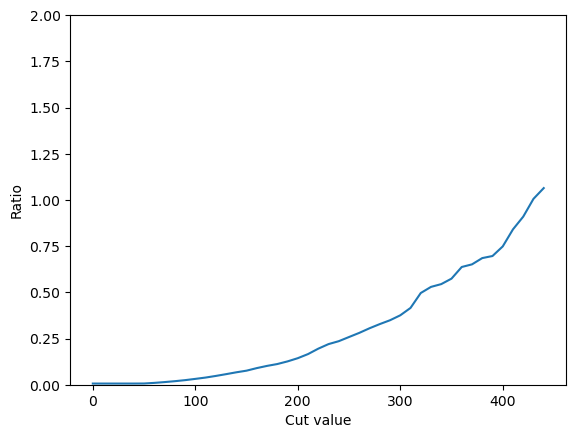

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


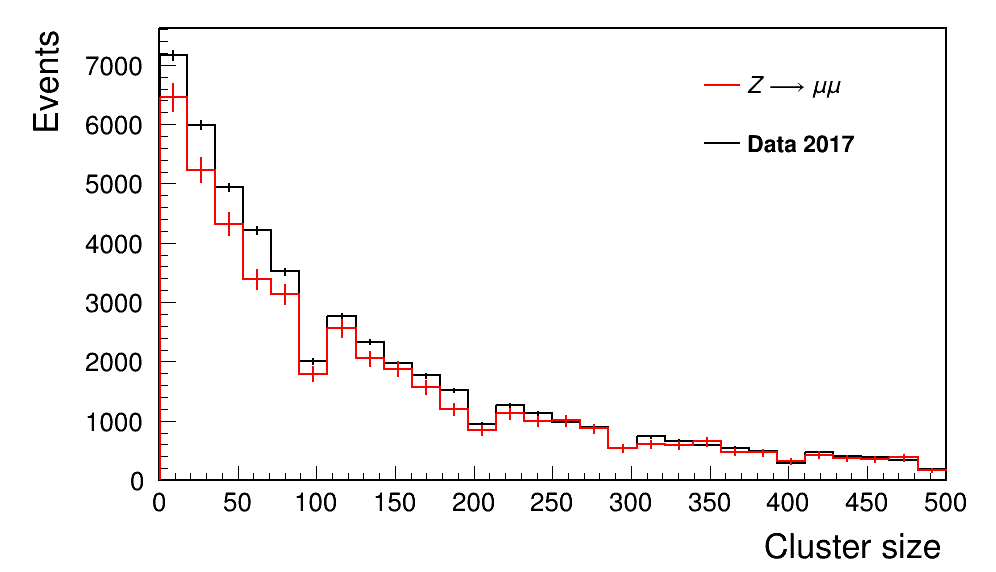

In [7]:
c = rt.TCanvas("", "", 1000, 600)
l = rt.TLegend(0.7, 0.7, 0.9, 0.9)

data = clusterSize['data17'][ak.count(clusterSize['data17'], axis = 1) != 0][:,0]
MC = clusterSize['dy_120_800'][ak.count(clusterSize['dy_120_800'], axis = 1) != 0][:,0]
data_weight = weight["data17"][ak.count(clusterSize['data17'], axis = 1) != 0]
MC_weight = weight["dy_120_800"][ak.count(clusterSize['dy_120_800'], axis = 1) != 0]

print(data_weight)
print(MC_weight)
print(MC)
print(data)

clusterSize_data = create_TH1D(data, weights = data_weight)
clusterSize_MC   = create_TH1D(MC, weights = MC_weight)

clusterSize_MC.GetXaxis().SetTitle("Cluster size")
clusterSize_data.GetXaxis().SetTitle("Cluster size")

clusterSize_MC.SetLineColor(rt.kRed)
clusterSize_data.SetLineColor(rt.kBlack)

clusterSize_MC.SetMarkerSize(0)
clusterSize_data.SetMarkerSize(0)

clusterSize_MC.GetYaxis().SetTitle("Events")
clusterSize_data.GetYaxis().SetTitle("Events")

clusterSize_MC.GetXaxis().SetLimits(0, 500)
clusterSize_data.GetXaxis().SetLimits(0, 500)

l.AddEntry(clusterSize_MC, "Z \longrightarrow \mu \mu")
l.AddEntry(clusterSize_data, "Data 2017")
clusterSize_data.Draw("hist E")
clusterSize_MC.Draw("SAME hist E")
l.Draw("same")
c.Draw()

diff = []

print(f"The efficiency of the ClusterSize > 390 (Data): {100 * len(data[data > 390]) / len(data)}")
print(f"The efficiency of the ClusterSize > 390 (MC): {100 * sum(MC_weight[MC > 390]) / sum(MC_weight)}")
print(f"Diff: {(abs((len(data[data > 220]) / len(data)) / (len(MC[MC > 390]) / len(MC))))}")
print()
print("Scan the cut values.")
for i in range(0, 450, 10):
    print()
    print(f"Cut value: {i}")
    print(f"The efficiency of the ClusterSize > 390 (Data): {100 * len(data[data > 390]) / len(data)}")
    print(f"The efficiency of the ClusterSize > {i} (MC): {100 * sum(MC_weight[MC > i]) / sum(MC_weight)}")
    print(f"Diff: {(abs((len(data[data > 390]) / len(data)) / (sum(MC_weight[MC > i]) / sum(MC_weight))))}")
    diff.append((abs((len(data[data > 390]) / len(data)) / (sum(MC_weight[MC > i]) / sum(MC_weight)))))
plt.plot(range(0, 450, 10), diff)
plt.ylabel("Ratio")
plt.ylim(0, 2)
plt.xlabel("Cut value")
plt.show()

In [18]:
ak.sum(selecting_re12)

NameError: name 'selecting_re12' is not defined

In [7]:
ak.sum(selecting_me1112)

12349

In [8]:
rpcR

<Array [[370], [370, 370], ... [], [369], []] type='132547 * var * float32'>

In [9]:
(abs(re12_Z["data17"]))

<Array [[726, 695], [726, ... 726], [], []] type='346102 * var * float32'>

In [10]:
ak.sum((rpcR < 470) & (rpcR > 380))

0

In [11]:
((rpcR < 470) & (rpcR > 380) & (abs(re12_Z["dy_120_800"]) < 661))

<Array [[False], [False, ... [False], []] type='132547 * var * bool'>

In [12]:
k = "dy_120_800"
rpcR = np.sqrt(rb1_X[k]**2 + rb1_Y[k]**2)
(rpcR < 470) & (rpcR > 380)

<Array [[True], [True, ... True, True, True]] type='132547 * var * bool'>

In [13]:
req

<Array [[False], [False, ... [False], []] type='132547 * var * bool'>

# Print the inclusive efficiencies.

In [5]:
total_integral_data = []
total_integral_dy = []
total_integral_diff = []
total_integral_data_err = []
total_integral_dy_err = []
total_integral_diff_err = []
rows = []
for i in signal_samples:
    i = i.split(".root")[0]
    key = list(integral[i]["eff_data"].keys())[0]
    rows.append(f'{i} : {key}')
    total_integral_data.append(integral[i]["eff_data"][key])
    total_integral_dy.append(integral[i]["eff_dy"][key])
    total_integral_diff.append(integral[i]["diff"][key])
    total_integral_data_err.append(integral[i]["eff_data_err"][key])
    total_integral_dy_err.append(integral[i]["eff_dy_err"][key])
    total_integral_diff_err.append(integral[i]["diff_err"][key])
table     = {"": rows, "Data efficiency (%)": total_integral_data, "DY efficiency (%)": total_integral_dy, "Efficiency relation (Data / MC)": total_integral_diff}
table_err = {"": rows, "Data efficiency (%)": total_integral_data_err, "DY efficiency (%)": total_integral_dy_err, "Efficiency relation (Data / MC)": total_integral_diff_err}
print(pd.DataFrame(table))
print(pd.DataFrame(table_err))

                                                      Data efficiency (%)  \
0   PhiToPi0Pi0_mPhi0p3_ctau300 : probe_muon_cluster            96.664278   
1  PhiToPi0Pi0_mPhi1p0_ctau1000 : probe_muon_cluster            98.168459   
2  PhiToPiPlusPiMinus_mPhi0p3_ctau300 : probe_muo...            97.352226   
3  PhiToPiPlusPiMinus_mPhi1p0_ctau1000 : probe_mu...            97.280859   
4  PhiToPiPlusPiMinus_mPhi1p0_ctau300 : probe_muo...            97.529341   

   DY efficiency (%)  Efficiency relation (Data / MC)  
0          96.496153                         1.001742  
1          98.114822                         1.000547  
2          97.420527                         0.999299  
3          97.289821                         0.999908  
4          97.432681                         1.000992  
                                                      Data efficiency (%)  \
0   PhiToPi0Pi0_mPhi0p3_ctau300 : probe_muon_cluster             0.030532   
1  PhiToPi0Pi0_mPhi1p0_ctau1000 : probe_muon_cl

# Plotting variables.

In [15]:
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
# var   = [ZMass, ZPt, nJets, nJets2,npv]
# title = ['Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'Number of Jets', 'Number of Jets','npv']
# bins  = [[25,120,800], [0,20,40,60,80,100,200,300,400,500,600,1200], [10,0,20], [15,0,15], [20,0,160]]
# names = ['ZMass','ZPt', 'nJets','nJets_eta2', 'npv']
# ratio = [[0.5,1.5], [0.0,2], [0.5,1.5],[0.5,3],[0.5,5]]

# var   = [nMuons, mb1_eta, mb1_phi, stations]
# title = ['NMuons', "mb1_eta", "mb1_phi", "stations"]
# bins  = [[20, 0, 20], [30, 0, 4], [30, -4, 4], [10, 0, 5]]
# names = ['NMuons', "mb1_eta", "mb1_phi", "stations"]
# ratio = [[0.5,1.5], [-1.5,1.5], [-1.5,1.5], [-1.5, 1.5]]

var   = [mb1_eta, mb1_phi]
title = ["mb1_eta", "mb1_phi"]
bins  = [[30, -4, 4], [30, -4, 4]]
names = ["mb1_eta", "mb1_phi"]
ratio = [[-1.5,1.5], [-1.5,1.5]]

assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )

# dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/jet_veto_eff/'
dir_name = './Veto_efficiency/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)

datasets = ["data17", "dy_120_800"]

reweight  = 0
reweight_index = 1
for j in range(len(bins)):
    c = rt.TCanvas('c','c', 1600, 1200)
    # if not j == 1: continue
    for i, k in enumerate(datasets):
        total_weight = weight[k]
        # print(weight[k][0])
#         if 'dy' in k: total_weight *= lepOverallSF[k]
        if 'data17' in k: total_weight = total_weight * 0.0 + 1
        ###########
        # reweight
        ##########
        if ('dy' in k) and reweight:
            print(np.sum(total_weight))
            h_reweight = {}
            print("reweight",names[reweight_index], "plot", names[j])
            h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = total_weight)
            h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data17']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index])
            for key, v in h_reweight.items():v.Scale(1./v.Integral())
            h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
            reweight = []
            for m in range(len(var[j][k])):
                reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
            total_weight = total_weight * reweight
        # print(k, len(var[j][k]))
        # if "dy" in k:
        # print(var[j][k].layout.minmax_depth)
        if var[j][k].layout.minmax_depth == (1,1):
            print()
            print((1,1))
            print(title[j])
            print(len(np.abs(var[j][k])))
            print(len(total_weight))
            h[k] = create_TH1D(var[j][k], 'hm1', axis_title = [title[j],'Events'], binning=bins[j])
        else:
            variable = ak.flatten(var[j][k], axis = 1)
            tot_weights = np.ones_like(variable) / len(variable) # [ak.count(var[j][k], axis=1) > 0]
            print()
            print((2,2))
            print(title[j])
            print(variable)
            print(tot_weights)
            h[k] = create_TH1D(variable, 'hm1', axis_title = [title[j],'Events'], binning=bins[j], weights = tot_weights)
        # else:
        #    h[k] = create_TH1D(np.abs(var[j][k]), 'hm1', axis_title = [title[j],'Events'], binning=bins[j]) # , weights = total_weight)
        h[k].SetLineColor(std_color_list[i])
        h[k].SetLineWidth(3)
        h[k].Scale(1.0/h[k].Integral())
        h[k].GetYaxis().SetRangeUser(0, 1)
        h[k].Draw("SAME HIST")
        # print(k,h[k].Integral(),len(total_weight))
    # c = make_ratio_plot([h['dy_120_800'],h['data17']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
    c.Draw()
    
    if not reweight:
        c.SaveAs(dir_name+names[j]+'.png')
        c.SaveAs(dir_name+names[j]+'.C')
    else:
        c.SaveAs(dir_name+names[j]+'_reweight'+names[reweight_index]+'.png')
        c.SaveAs(dir_name+names[j]+'_reweight'+names[reweight_index]+'.png')


KeyError: 'data17'